In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [2]:
%matplotlib inline

In [3]:
t = np.linspace(0, 2*np.pi, 1000)

In [4]:
x = 10*np.cos(2*t)
y = 10*np.sin(t)*t
z = 10*np.sin(2*t)

In [5]:
Y = np.vstack([x, y, z])

In [6]:
angle = (3/4)*np.pi
angle=0
R = np.array([[1, 0, 0],[0, np.cos(angle), -np.sin(angle)], [0, np.sin(angle), np.cos(angle)]])

In [7]:
Y_data = R @ Y

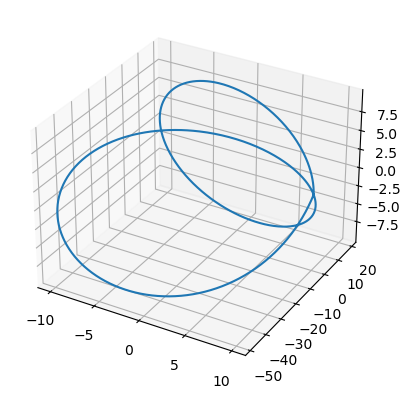

In [8]:
%matplotlib inline
ax = plt.figure().add_subplot(projection='3d')
ax.plot(Y_data[0], Y_data[1], Y_data[2])

In [9]:
Y_data = torch.tensor(Y_data)

In [10]:
Y_data = Y_data.T

In [11]:
C = torch.cdist(Y_data, Y_data)

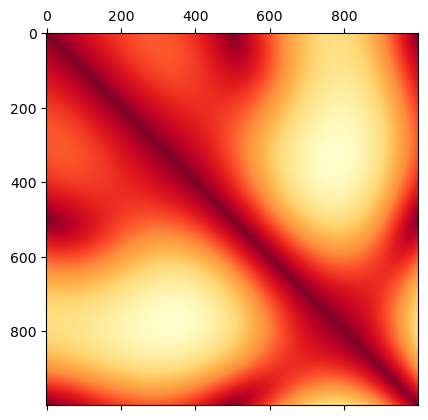

In [12]:
plt.matshow(C, cmap='YlOrRd_r')

In [13]:
X = torch.tensor(t).type(torch.float)[:, None]
Y = C.type(torch.float)

In [14]:
from gpzoo.gp import SVGP
from gpzoo.kernels import NSF_RBF
from torch import nn
from torch import optim
from tqdm.autonotebook import tqdm
from torch import distributions

/gladstone/engelhardt/home/lchumpitaz/gitclones/GPzoo/gpzoo/utilities.py:2: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [15]:
class CustomLikelihood(nn.Module):
    def __init__(self, gp, noise=0.1):
        super().__init__()
        self.gp = gp

        self.noise = nn.Parameter(torch.tensor(noise))

    def forward(self, X, E=1, verbose=False, **kwargs):
        qF, qU, pU = self.gp(X, verbose=verbose, **kwargs)
        F = qF.rsample((E, ))
        F = torch.transpose(F, -1, -2)
        dist_mat = torch.cdist(F, F)
#         dist_mat = dist_mat.view(-1)
        
        noise = torch.nn.functional.softplus(self.noise) #ensure positive
        pY = distributions.Normal(dist_mat, noise)

        return pY, qF, qU, pU

In [16]:
L = 3
M = 500
idx = torch.multinomial(torch.ones(X.shape[0]), num_samples=M, replacement=False)
kernel = NSF_RBF(L=L, sigma=0.5, lengthscale=1.2)
gp = SVGP(kernel, M=M, jitter=1e-1)
gp.Lu = nn.Parameter(1e-2*torch.eye(M).expand(L, M, M).clone())
gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)
mu =  torch.squeeze(torch.stack((torch.torch.sin(gp.Z), torch.cos(gp.Z), torch.sin(gp.Z))))

gp.mu = nn.Parameter(mu)


/tmp/ipykernel_894643/2414440679.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gp.Z = nn.Parameter(torch.tensor(X[idx]), requires_grad=False)


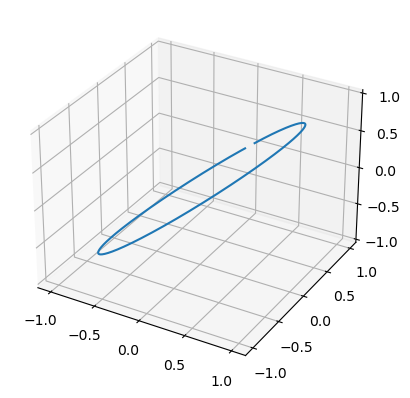

In [17]:
import matplotlib.pyplot as plt

ax = plt.figure().add_subplot(projection='3d')

qF, _, _ = gp(X)
some_mean = qF.mean.detach().numpy()

ax.plot(some_mean[0], some_mean[1], some_mean[2])

In [18]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [19]:
model = CustomLikelihood(gp=gp, noise=0.1)
model.to(device)

CustomLikelihood(
  (gp): SVGP(
    (kernel): NSF_RBF()
  )
)

In [20]:
X_train = X.to(device)
Y_train = Y.to(device)

In [21]:
def train(model, optimizer, X, y, device, steps=200, E=20, **kwargs):
    losses = []

    means = []
    scales = []

    for it in tqdm(range(steps)):

        optimizer.zero_grad()
        pY, qF, qU, pU = model.forward(X=X, E=E, **kwargs)
        if (it%10)==0:
            means.append(qF.mean.detach().cpu().numpy())
            scales.append(qF.scale.detach().cpu().numpy())

        logpY = pY.log_prob(y)

        ELBO = (logpY).mean(axis=0).sum()
        ELBO -= torch.sum(distributions.kl_divergence(qU, pU))

        loss = -ELBO
        loss.backward()
        optimizer.step()

        losses.append(loss.item())

    with torch.no_grad():
        if device.type=='cuda':
            torch.cuda.empty_cache()

    return losses, means, scales

In [22]:
kernel.lengthscale.requires_grad = False
kernel.sigma.requires_grad = False
model.noise.requires_grad=False
gp.Lu.requires_grad=False

In [23]:
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=2e-2)

In [24]:
model.to(device)
losses, means, scales = train(model, optimizer, X_train, Y_train, device, steps=5000, E=100)

  0%|          | 0/5000 [00:00<?, ?it/s]

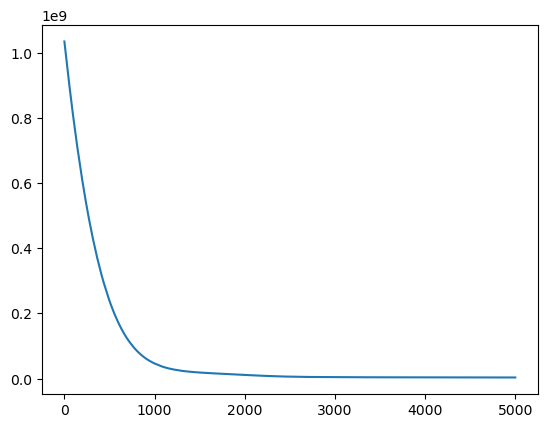

In [25]:
plt.plot(losses)

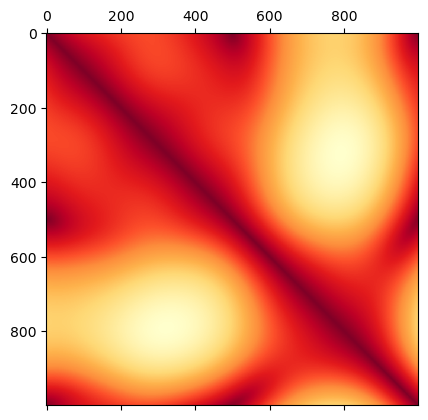

In [26]:
curr_mean = torch.tensor(means[-1].T)
mat = torch.cdist(curr_mean, curr_mean)
plt.matshow(mat, cmap='YlOrRd_r')

In [27]:
def plot_mean(ax, curr_mean):
    ax.plot(curr_mean[0], curr_mean[1], curr_mean[2], label='parametric curve')
    ax.legend()

/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: FutureWarning: The input object of type 'Tensor' is an array-like implementing one of the corresponding protocols (`__array__`, `__array_interface__` or `__array_struct__`); but not a sequence (or 0-D). In the future, this object will be coerced as if it was first converted using `np.array(obj)`. To retain the old behaviour, you have to either modify the type 'Tensor', or assign to an empty array created with `np.empty(correct_shape, dtype=object)`.
  return np.array([xs, ys, zs, np.ones_like(xs)])
/gladstone/engelhardt/home/lchumpitaz/miniconda3/envs/nsf/lib/python3.9/site-packages/mpl_toolkits/mplot3d/proj3d.py:210: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating

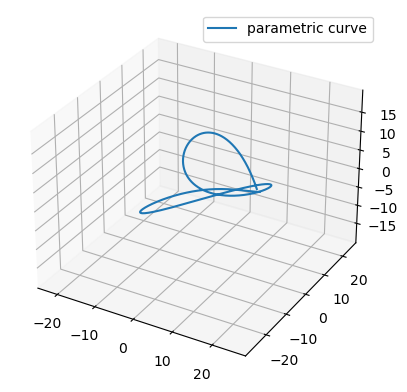

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
fig = plt.figure()
ax = fig.add_subplot(projection='3d')



plot_mean(ax, curr_mean.T)

In [29]:
len(means)

500

hi 0
hi 0
hi 10
hi 20
hi 30
hi 40
hi 50
hi 60
hi 70
hi 80
hi 90
hi 100
hi 110
hi 120
hi 130
hi 140
hi 150
hi 160
hi 170
hi 180
hi 190
hi 200
hi 210
hi 220
hi 230
hi 240
hi 250
hi 260
hi 270
hi 280
hi 290
hi 300
hi 310
hi 320
hi 330
hi 340
hi 350
hi 360
hi 370
hi 380
hi 390
hi 400
hi 410
hi 420
hi 430
hi 440
hi 450
hi 460
hi 470
hi 480
hi 490
hi 0


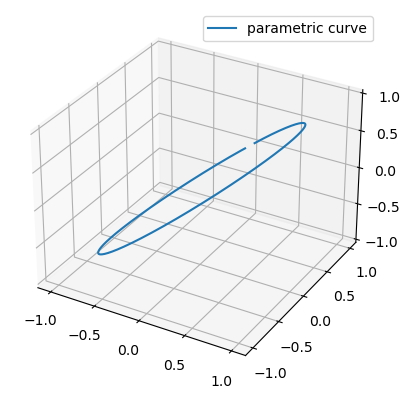

In [30]:
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation


fig = plt.figure()
ax = fig.add_subplot(projection='3d')

def update(iteration):
    ax.cla()
        
    curr_mean = means[iteration]
    
    
    plot_mean(ax, curr_mean)
#     fig.suptitle(f"Iteration: {iteration}, Loss: {losses[iteration*10]:0.2f}")
#     fig.tight_layout()
    print('hi', iteration)


anim = FuncAnimation(fig, update, frames=np.arange(0, 500, 10), interval=100)
# anim.save('pnmf.mp4',
#          writer=animation.FFMpegWriter(fps=50, bitrate=2000, codec='h264'),
#          dpi=50)
anim.save("3d_means_crazy_shape.mp4", fps=10, dpi=100)